# Creation of Clusters Classifier

## Load Data

In [1]:
sys.path.append('..')
from utils import *

/home/nvlaminc/Documents/Projects/Ariac/building/TRAIL_workshops/venv_workshop2022/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '../../QuickStart/Data/Electricity/residential_all_hour_with_date_time.pkl'
x_date_time = pd.read_pickle(file_path)
ids = x_date_time.columns.values

**Smooth Data**

In [3]:
x_date_time = gaussian_smoothing(x_date_time)

**Keep 1st Year**

In [4]:
df = x_date_time.sort_values(by='date_time')["2009-07-15" : "2010-07-14"]
x = np.array(df).T

**Outlier Removal**

In [5]:
id_remove = []

In [6]:
#Maximum- and variance-based outlier removal
for i in np.argsort(-x.max(1))[:10]:
    id_remove.append(i)
for i in np.argsort(-x.std(1))[:10]:
    id_remove.append(i)
id_remove = np.asarray(id_remove)

In [7]:
#Isolation Forest outlier removal
clf = IsolationForest(random_state=0, contamination = 0.01, n_jobs=-1).fit(x)
pred = clf.predict(x)

In [8]:
#Concatenate and delete the outliers
id_remove = np.concatenate((id_remove, np.squeeze(np.argwhere((pred==-1)))))
id_remove = np.unique(id_remove)
print(f'Shape before removing outlier {x.shape}.')
x = np.delete(x, id_remove, 0)
ids = np.delete(ids, id_remove, 0)
print(f'Shape after removing outlier {x.shape}.')

Shape before removing outlier (3639, 8760).
Shape after removing outlier (3595, 8760).


## 0. Define Parameters

In [9]:
n_components = 10
n_clusters = 4
do_plot = True

## 1. KMeans Clustering

### Prepare signals

**Generate KMeans clustering**

Number of PCA components: 10
Number of clusters: 4
Time to cluster the dataset 2.44 s.


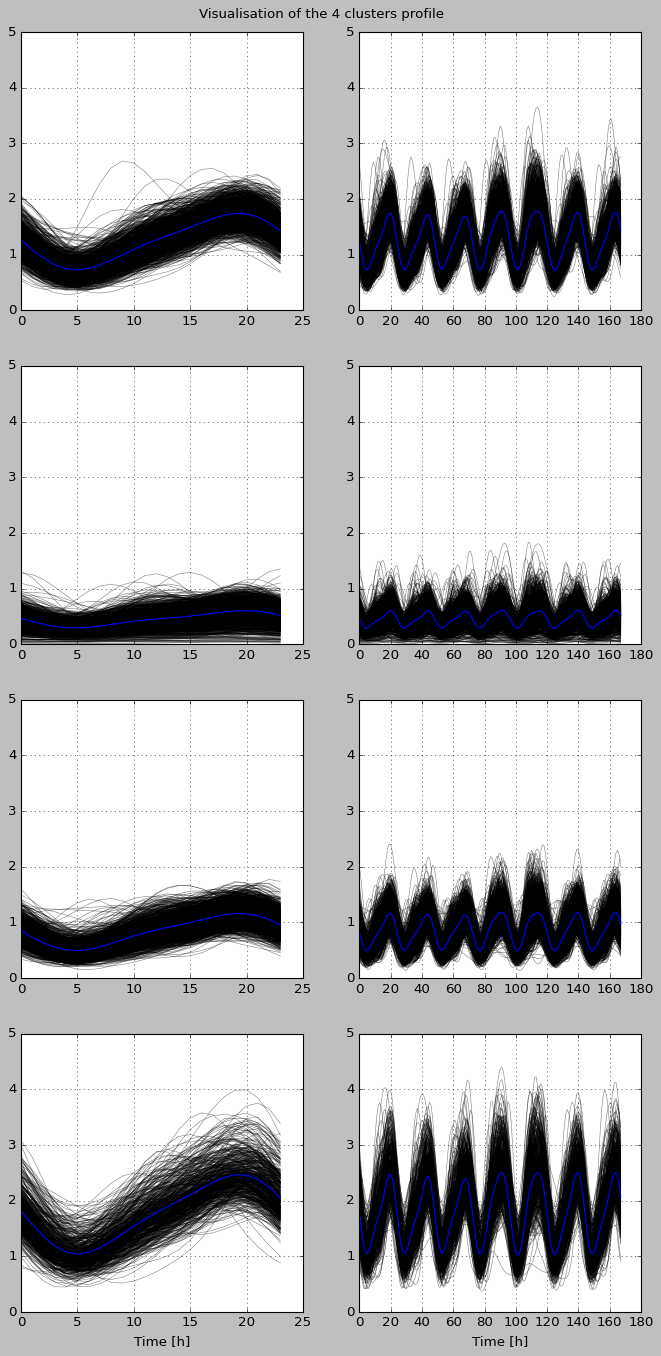

In [10]:
print(f'Number of PCA components: {n_components}')
print(f'Number of clusters: {n_clusters}')
t = time.time()
x_pca = PCA(n_components=n_components).fit_transform(x)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x_pca)
print(f'Time to cluster the dataset {time.time()-t:.2f} s.')
if do_plot:
    plot_clusters(x, kmeans.predict(x_pca))

**Compute Centroids**

In [14]:
clusters = []

for c in range(n_clusters):
    print(f'Population of cluster {c+1} for kmean is {(kmeans.predict(x_pca)==c).sum()}')
    tmp = {}
    tmp['labels'] = c
    tmp['centroid'] = x[kmeans.predict(x_pca) == c].mean(0)
    tmp['ids'] = ids[kmeans.predict(x_pca) == c]
    clusters.append(tmp)

Population of cluster 1 for kmean is 970
Population of cluster 2 for kmean is 978
Population of cluster 3 for kmean is 1139
Population of cluster 4 for kmean is 508


## 2. Spectral Clustering

### Prepare signals

**Generate Spectral clustering**

Number of PCA components: 10
Number of clusters: 4
Time to cluster the dataset 9.70 s.


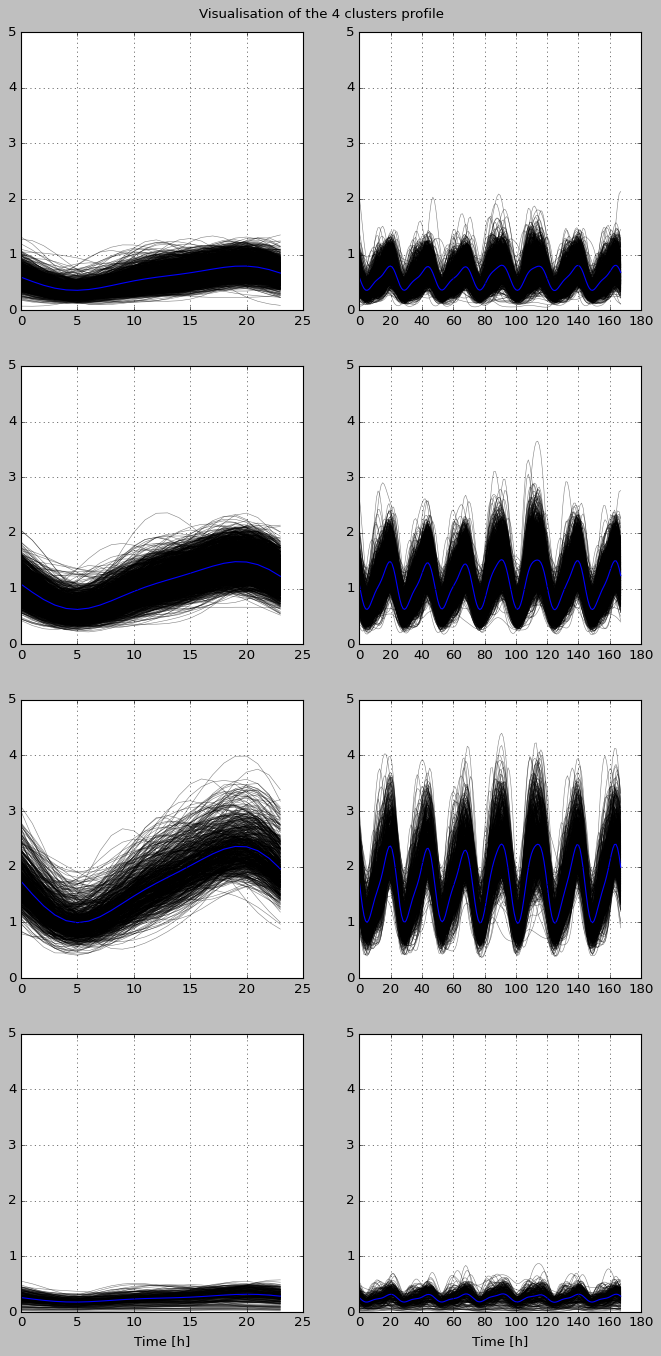

In [21]:
print(f'Number of PCA components: {n_components}')
print(f'Number of clusters: {n_clusters}')
t = time.time()
x_pca = PCA(n_components=n_components).fit_transform(x)
scluster = SpectralClustering(n_clusters=n_clusters, random_state=0, affinity = "nearest_neighbors").fit(x_pca)
print(f'Time to cluster the dataset {time.time()-t:.2f} s.')
if do_plot:
    plot_clusters(x, scluster.labels_)

**Compute Centroids**

In [25]:
clusters = []
for c in range(n_clusters):
    print(f'Population of cluster {c+1} for spectral clustering is {(scluster.labels_==c).sum()}')
    tmp = {}
    tmp['labels'] = c
    tmp['centroid'] = x[scluster.labels_ == c].mean(0)
    tmp['ids'] = ids[scluster.labels_== c]
    clusters.append(tmp)

Population of cluster 1 for spectral clustering is 1152
Population of cluster 2 for spectral clustering is 1550
Population of cluster 3 for spectral clustering is 661
Population of cluster 4 for spectral clustering is 232


## 3. Self-Organised Maps

### Prepare signals

**Generate SOM clustering**

Number of PCA components: 10
Number of clusters: 4
Time to cluster the dataset 2.42 s.


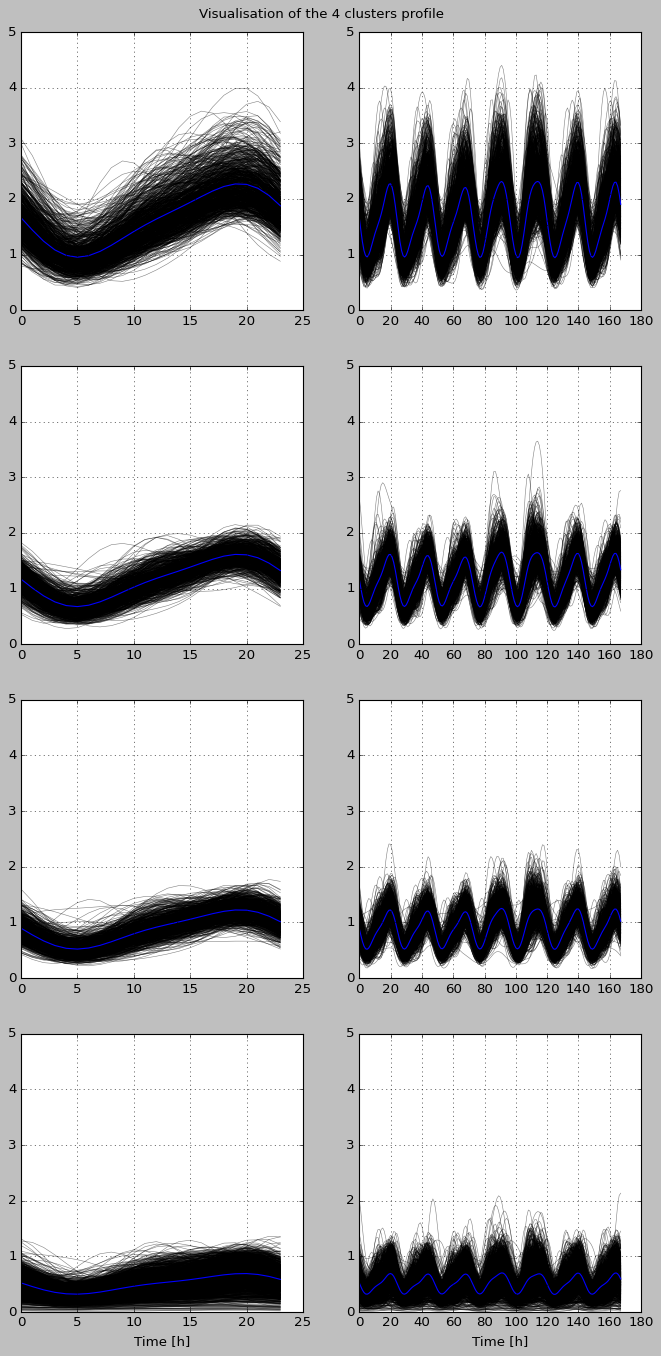

In [23]:
print(f'Number of PCA components: {n_components}')
print(f'Number of clusters: {n_clusters}')
t = time.time()
x_pca = PCA(n_components=n_components).fit_transform(x)
som = susi.SOMClustering(n_rows=1,n_columns=n_clusters)
som.fit(x_pca)
cluster_coord = pd.DataFrame(np.array(som.get_clusters(x_pca)), columns = ["dim1", "dim2"])
print(f'Time to cluster the dataset {time.time()-t:.2f} s.')
labels_ = cluster_coord.groupby(['dim1', 'dim2']).grouper.group_info[0]
if do_plot:
    plot_clusters(x, labels_)

**Compute Centroids**

In [24]:
clusters = []
for c in range(n_clusters):
    print(f'Population of cluster {c+1} for SOM is {(labels_==c).sum()}')
    tmp = {}
    tmp['labels'] = c
    tmp['centroid'] = x[labels_ == c].mean(0)
    tmp['ids'] = ids[labels_ == c]
    clusters.append(tmp)

Population of cluster 1 for SOM is 832
Population of cluster 2 for SOM is 696
Population of cluster 3 for SOM is 773
Population of cluster 4 for SOM is 1294


## X. Training Deep Learning Model for Clustering/Forecasting

### Train Models

**Generate Training Signals**

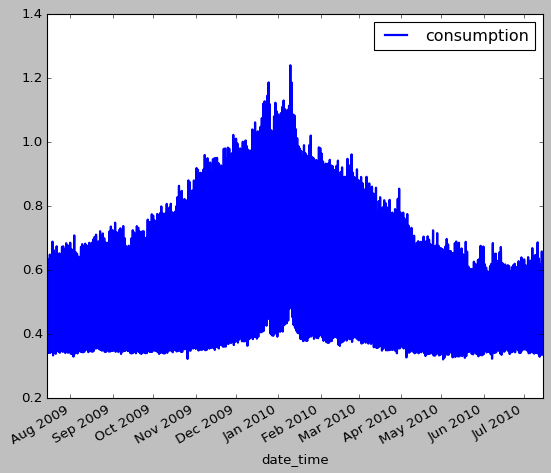

In [27]:
c = 0
df = pd.DataFrame()
df['consumption'] = clusters[c]['centroid']
df['date_time'] = pd.date_range(start="2009-07-15", end="2010-07-14 23:00:00", freq="60T", name='date_time')
df = df.set_index('date_time')
train_series = darts.TimeSeries.from_dataframe(df)
if do_plot:
    train_series.plot()

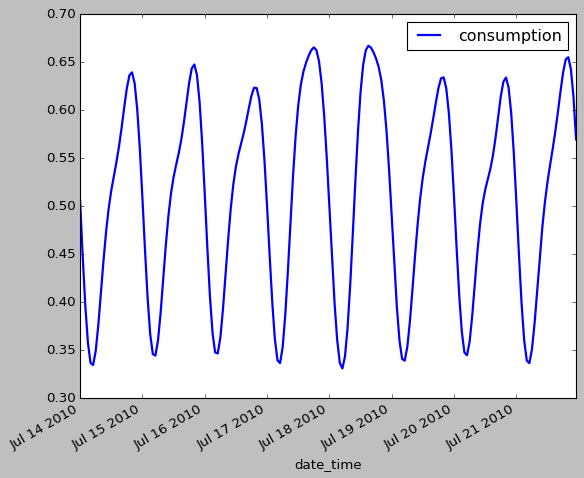

In [29]:
#Compute the centroid of the following week
conso = x_date_time.sort_values(by='date_time')["2010-07-14" : "2010-07-21"][clusters[c]['ids']].values.mean(1)
df = pd.DataFrame()
df['date_time'] = pd.date_range(start="2010-07-14", end="2010-07-21 23:00:00", freq="60T", name='date_time')
df['consumption'] = conso
df = df.set_index('date_time')
val_series = darts.TimeSeries.from_dataframe(df)
if do_plot:
    val_series.plot()

**Create the model**

In [32]:
#Init args
directory = 'test_cluster/som/'
os.makedirs(directory, exist_ok = True)
model_name = f"RNN_test_{c}"
torch_metrics = MeanSquaredError()
my_stopper = EarlyStopping(
    monitor="val_MeanSquaredError",  # "val_loss",
    patience= 7,
    min_delta=0.0025,
    mode='min',)
kwargs = {"accelerator": "gpu", "gpus": [0], "auto_select_gpus": True, "callbacks": [my_stopper]}

In [33]:
model = RNNModel(model = "LSTM" , input_chunk_length=7*24, training_length=7*24, random_state = 42, n_epochs = 20, 
                 save_checkpoints = True, work_dir = directory, n_rnn_layers = 3, hidden_dim = 25, model_name = model_name, 
                 log_tensorboard = True, force_reset = True, torch_metrics = torch_metrics, pl_trainer_kwargs = kwargs)

**Train the model**

In [34]:
model.fit(series=train_serie, val_series=val_series)

/home/nvlaminc/Documents/Projects/Ariac/building/TRAIL_workshops/venv_workshop2022/lib64/python3.8/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
/home/nvlaminc/Documents/Projects/Ariac/building/TRAIL_workshops/venv_workshop2022/lib64/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
-------------------------------

Epoch 10: 100%|██████████| 270/270 [00:11<00:00, 24.31it/s, loss=3.35e-05, v_num=logs, train_loss=3.42e-5, val_loss=1.54e-5, val_MeanSquaredError=1.54e-5, train_MeanSquaredError=3.91e-5]   


**Validation and Metrics**

In [35]:
pred_serie = model.predict(n=len(val_series))
pred, true = compute_intersect(pred_serie, val_series)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


In [37]:
metrics = [rmse(true, pred), coefficient_of_variation(true, pred), biased_error(true.values(), pred.values())]
np.save(os.path.join(directory, model_name, 'logs', 'metrics'), metrics)